# __Image Classification Using CNN__

Let's see a working example of training a convolutional neural network (CNN) on a dataset of flower images.

## Steps to be followed:

1. Import the necessary libraries and dataset
2. Count and retrieve the images
3. Create a training dataset
4. Create a validation dataset
5. Visualize a subset of images from the training dataset
6. Preprocess and normalize the training dataset
7. Create a convolutional neural network model with data augmentation
8. Summarize and compile the model
9. Train the model
10. Visualize the result
11. Predict the class of a given image

### Step 1: Import the necessary libraries and dataset
- Import the required libraries.
- Import the given dataset using the link provided.

In [18]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Set CUDA_VISIBLE_DEVICES:
#   "-1" -> force CPU-only execution
#   "0"  -> use first GPU (change to "1", "2", etc. for other GPUs)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [20]:
# Load the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

### Step 2: Count and retrieve the images
- Count the number of images in the directory specified by **data_dir** and print the count.
- Retrieve the file paths of the images in the **roses** subdirectory and display the first two images.
- Retrieve the file paths of the images in the __tulips__ subdirectory and display the first image.

Total images: 3670


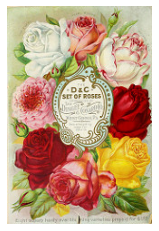

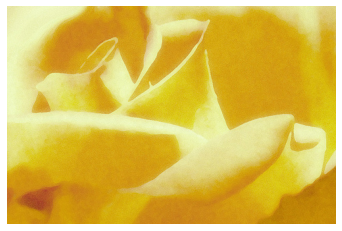

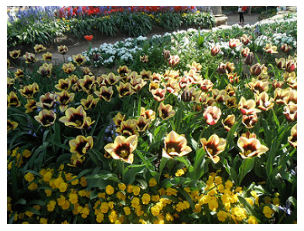

In [21]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total images: {image_count}')

# Retrieve file paths
roses = list(data_dir.glob('roses/*'))
tulips = list(data_dir.glob('tulips/*'))

def display_image(image_path):
    img = Image.open(str(image_path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# Display the first two rose images and the first tulip image
if len(roses) > 1:  # Make sure there are at least two rose images
    display_image(roses[0])
    display_image(roses[1])

if len(tulips) > 0:  # Make sure there is at least one tulip image
    display_image(tulips[0])

### Step 3: Create a training dataset
- Set the batch size, image height, and image width variables.
- Create a training dataset using **tf.keras.utils.image_dataset_from_directory()** function, passing the following parameters:
  - __data_dir:__ The directory containing the image dataset
  - **validation_split**: The fraction of data to reserve for validation
  - **subset**: Specify the subset of the dataset to use (in this case, training)
  - **seed**: Random seed for shuffling the data
  - **image_size**: The desired size for the images in the dataset
  - **batch_size**: The number of samples per batch


In [22]:
# Set parameters for dataset
batch_size = 32
img_height = 180
img_width = 180

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


__Observation:__
- The **train_ds** object represents the training dataset.

### Step 4: Create a validation dataset
- Create a validation dataset using **tf.keras.utils.image_dataset_from_directory()** function, passing the following parameters:
  - __data_dir:__ The directory containing the image dataset
  - **validation_split**: The fraction of data to reserve for validation
  - **subset**: Specify the subset of the dataset to use (in this case, validation)
  - **seed**: Random seed for shuffling the data
  - **image_size**: The desired size for the images in the dataset
  - **batch_size**: The number of samples per batch

In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


__Observation:__
- The __val_ds__ object represents the validation dataset.

### Step 5: Visualize a subset of images from the training dataset
- Obtain the class names from the train_ds dataset using the class_names attribute.
- Print the **class_names** to display the list of class labels.
- Import the **matplotlib.pyplot** module for visualization purposes.
- Create a figure with a size of 10x10 using **plt.figure(figsize=(10, 10)).**
- Iterate over the first batch of images and labels in the **train_ds** dataset using **train_ds.take(1).**
- For each image in the batch (up to 9 images), create a subplot using **plt.subplot(3, 3, i + 1).**
- Display the image using **plt.imshow(images[i].numpy().astype("uint8")).**
- Set the title of the subplot to the corresponding class name using **plt.title(class_names[labels[i]]).**
- Disable the axis labels for the subplot using __plt.axis("off")__.

In [24]:
class_names = train_ds.class_names
print(f'Class names: {class_names}')

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2025-09-08 06:19:30.507500: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


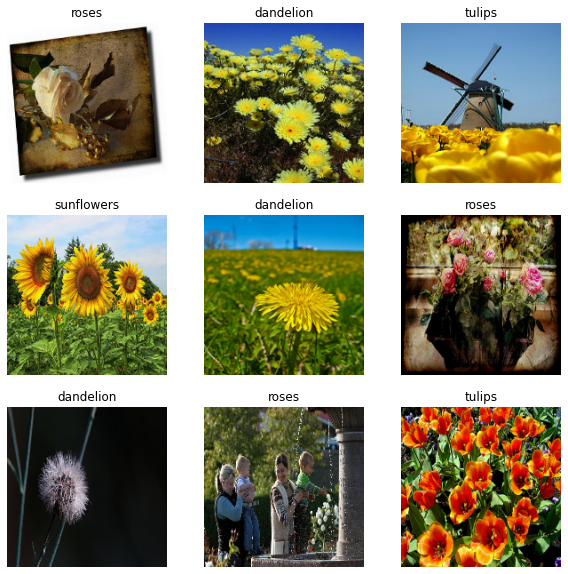

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

__Observation:__


### Step 6: Preprocess and normalize the training dataset
- Set the value of **AUTOTUNE** to **tf.data.AUTOTUNE.**
- Cache the **train_ds** dataset for improved performance by calling the **cache()** method.
- Shuffle the elements of the **train_ds** dataset using a buffer size of **1000** by calling the **shuffle()** method.
- Prefetch the elements of the **train_ds** dataset for improved performance by calling the **prefetch()** method with **buffer_size=AUTOTUNE.**
- Cache the **val_ds** dataset for improved performance by calling the **cache()** method.
- Prefetch the elements of the **val_ds** dataset for improved performance by calling the **prefetch()** method with **buffer_size=AUTOTUNE.**
- Create a __Rescaling__ layer to normalize the pixel values of the dataset images to the range **[0, 1].**
- Apply the __normalization_layer__ to the **train_ds_nm** dataset using the **map()** method and **lambda** function.
- Apply the __normalization_layer__ to the __val_ds_nm__ dataset using the __map__() method and a lambda function:
- Retrieve a batch of images and labels from the normalized dataset using **next(iter(normalized_train_ds_nm)).**
- Access the first image in the batch using **image_batch[0].**
- Print the minimum and maximum pixel values of the first image using **np.min(first_image)** and __np.max(first_image)__.


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_nm = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_nm = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./255)

normalized_train_ds_nm = train_ds_nm.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_nm = val_ds_nm.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_train_ds_nm))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


__Observation:__
- The range of pixel values in the normalized dataset ensures that the minimum value is 0 and the maximum value is 1 for the first image. This normalization process allows for consistent and standardized pixel values, facilitating easier comparisons and computations in subsequent analysis.

### Step 7: Create a convolutional neural network model with data augmentation
- Create a data augmentation pipeline using **keras.Sequential** with three augmentation layers: random horizontal flip, random rotation, and random zoom.
- Determine the number of classes based on the **class_names.**
- Create a sequential model with data augmentation as the first layer and rescaling layer.
- Add convolutional layers with an increasing number of filters, 3x3 kernel, padding, and ReLU activation.
- Add max pooling layers after each convolutional layer.
- Add a dropout layer with a rate of **0.2**.
- Add dense layers with ReLU activation, ending with a dense output layer.

In [28]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dropout(0.5),  # Add dropout before the dense layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

__Observation:__
- The output of this code is a convolutional neural network model with data augmentation, suitable for image classification tasks.

### Step 8: Summarize and compile the model
- Display the summary of the model architecture and the number of parameters.


In [36]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,967,857 (45.65 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,978,572 (30.44 MB)

- Compile the model with the specified optimizer, loss function, and metrics.

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

__Observation:__
- The summary of the model architecture and the compiled model can be seen as output.

### Step 9: Train the model
- Set the number of epochs to 3
- Train the model using the fit method and pass the normalized training and validation datasets and the number of epochs

In [31]:
epochs = 5
history = model.fit(
  normalized_train_ds_nm,
  validation_data=normalized_val_ds_nm,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 365ms/step - accuracy: 0.2373 - loss: 1.6031 - val_accuracy: 0.2398 - val_loss: 1.6037
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.2452 - loss: 1.6034 - val_accuracy: 0.2398 - val_loss: 1.6022
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 360ms/step - accuracy: 0.2462 - loss: 1.6004 - val_accuracy: 0.2398 - val_loss: 1.6021
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.2557 - loss: 1.5963 - val_accuracy: 0.2398 - val_loss: 1.6022
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.2360 - loss: 1.6011 - val_accuracy: 0.2398 - val_loss: 1.6027


__Observation:__
- The training history object provides valuable information about the training process, including the loss and accuracy values for each epoch. This object allows us to track the performance of the model over time and analyze how the loss and accuracy metrics evolve during training.

In [32]:
# Print the training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(f"Train Accuracy: {acc[-1]:.2f}")
print(f"Validation Accuracy: {val_acc[-1]:.2f}")



Train Accuracy: 0.25
Validation Accuracy: 0.24


#### __Observation__
Accuracies are low, this can be catered to by:

1. **Increasing Training Duration**

  Sometimes, the model simply needs more epochs to learn effectively. However, keep an eye on the validation accuracy to avoid overfitting.

2. **Batch Normalization**

  Incorporating batch normalization layers may improve model convergence and overall accuracy by normalizing the activations of the previous layer.

3. **Regularization Techniques**

  Adding dropout layers can help prevent the model from overfitting to the training data, which can improve the validation accuracy.

Incorporate these techniques and see how the accuracy improves.

### Step 10: Visualize the result
- Retrieve the accuracy and loss values from the training history.
- Create a range of epochs.
- Plot the training and validation accuracy in a subplot.
- Plot the training and validation loss in a subplot.
- Display the plotted figures.

Text(0.5, 1.0, 'Training and Validation Accuracy')

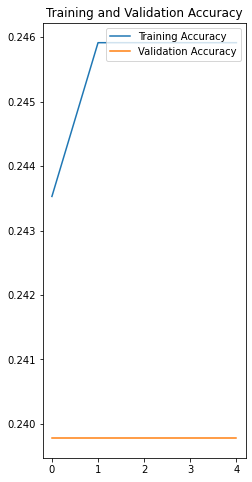

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

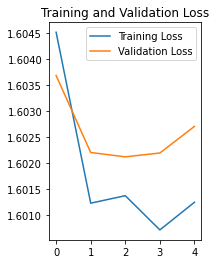

In [34]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__Observation:__
- Two subplots show the training and validation accuracy and the training and validation loss over the range of epochs.

### Step 11: Predict the class of a given image
- Define the URL of the image and download it using **tf.keras.utils.get_file().**
- Load the image and resize it to the desired target size.
- Convert the image to an array and expand its dimensions to create a batch.
- Make predictions on the image using the trained model.
- Calculate the softmax scores and identify the class with the highest confidence.
- Print the predicted class and its corresponding confidence percentage.

In [35]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
This image most likely belongs to dandelion with a 64.25 percent confidence.


__Observation:__
- The predicted class of the image and the confidence percentage are shown as an output.